# Lending Club Loan Default Prediction

### __Introduction__

Lending Club is platform for connecting borrowers and investors in United Sates, providing access to money for former and opportunity for profit for latter.  

Task at hand involves creating model predicting probability of loan default and through it help investors avoid unnecessary risks as well as allow borrowers to assess their financial viability.  

Additional value can be provided by explaining model's choices - both in terms of validating used features against common sense as well as outlining undesired financial behaviours for applicants.  

Dataset can be found at:  
https://www.kaggle.com/wendykan/lending-club-loan-data/downloads/lending-club-loan-data.zip/1  
Lending Club website with additional information regarding functioning of system:  
https://www.lendingclub.com/

XLS data dictionary file provides description of variables included in dataset (can be opened in other software, purposefully not included in this notebook as not to bloat output). Among them there are those that directly describe actions taken after loan defaulted or was charged off (such as debt settlement status or post charge-off recoveries) so they should be removed.

#### Imports

In [1]:
# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix

# misc
import warnings 
import gc

warnings.simplefilter(category='DeprecationWarning', action='ignore')
warnings.simplefilter(category='FutureWarning', action='ignore')

sns.set_style('white')
%matplotlib inline

np.random.seed(42)

pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 50)

#### Loading data

In [20]:
df = pd.read_csv('../data/lending_club/loan.csv', delimiter=',', low_memory=False)

In [21]:
print('Dataset contains {rows} rows and {columns} columns'.\
      format(rows = df.shape[0], columns = df.shape[1]))

Dataset contains 2260668 rows and 145 columns


Removal of columns pertaining to future state of loans:

In [25]:
unfair_columns = ['recoveries', 'collection_recovery_fee', 'debt_settlement_flag', 'debt_settlement_flag_date', \
                  'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage', \
                  'settlement_term', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', \
                  'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', \
                  'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', \
                  'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', \
                  'hardship_last_payment_amount', 'last_pymnt_d', 'last_pymnt_amnt']
df.drop(columns=unfair_columns, axis=1, inplace=True)

In [26]:
print('After removal of unfair columns dataset contains {rows} rows and {columns} columns'.\
      format(rows = df.shape[0], columns = df.shape[1]))

After removal of unfair columns dataset contains 2260668 rows and 121 columns


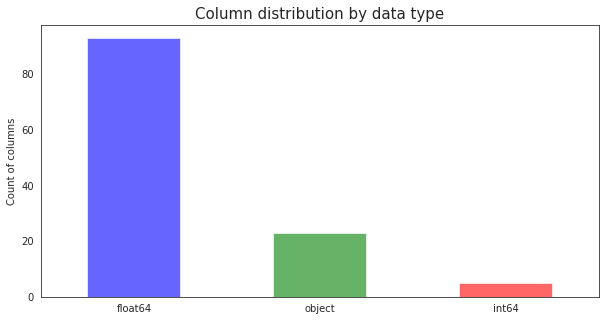

In [162]:
df.dtypes.value_counts().plot(kind='bar', color=['blue', 'green', 'red'], alpha=0.6)
plt.xticks(rotation=0)
plt.ylabel('Count of columns')
plt.title('Column distribution by data type', fontsize=15)
plt.show()

Most data is numerical, however around 20 columns are categorical and will require encoding.

#### Initial EDA of predicted variable

Initial analysis of predicted variable - "loan_status". Questions to answer:
- what is the distribution of different statuses
- what is a __ratio__ of paid loans to unpaid ones  

Answers to these questions will dictate method of modelling, particularly sampling if proportion of unpaid loans is really low.

In [28]:
df.loan_status.value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

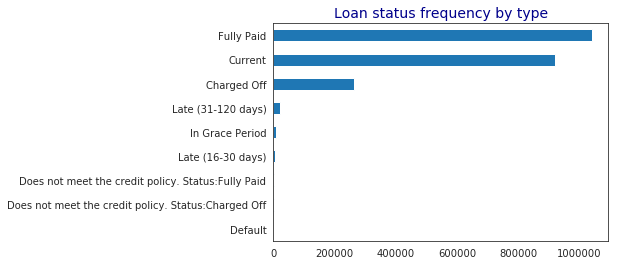

In [27]:
df.loan_status.value_counts().sort_values().plot(kind='barh')
plt.title('Loan status frequency by type', fontsize=14, color='darkblue')
plt.show()

Predicted variable consists of a variety of categories describing loan status. For this task __Current__ loans should be discarded (censored), as they can still turn to unpaid ones.  
Out of all loan types only small fraction are annotated as 'Default', however other statuses are also descriptions of unpaid loans. Based on those descriptions loan types will be divided into __positive__ and __negative__ classes. Positive class will consist of Fully Paid loans, negative class - of any late payments.  

In [42]:
df.drop(index=df.query('loan_status == "Current"').index, axis=0, inplace=True)

In [138]:
print('Number of observations left {}'.format(df.shape[0]))

Number of observations left 1340973


In [29]:
positive_loans = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
negative_loans = ['Charged Off', 'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',\
                  'Does not meet the credit policy. Status:Charged Off', 'Default']

In [48]:
df['loan_classes'] = df.loan_status.apply(lambda x: 1 if x in positive_loans else 0)

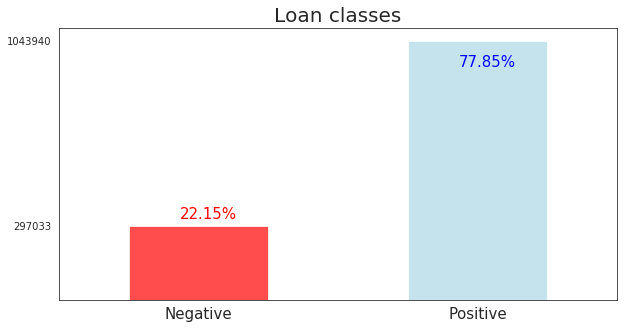

In [421]:
df.loan_classes.value_counts().sort_values().plot(kind='bar', color=('red', 'lightblue'), alpha=0.7)

pos, neg = df.loan_classes.value_counts(ascending=False)

plt.title('Loan classes', fontsize=20)
plt.yticks([ neg, pos ])
plt.xticks([0, 1], labels=('Negative', 'Positive'), rotation=0, fontsize=15)
plt.annotate('{:3.2f}%'.format(neg/df.shape[0]*100), xy=(0 - 1/15, neg*1.1), color='red', fontsize=15)
plt.annotate('{:3.2f}%'.format(pos/df.shape[0]*100), xy=(1 - 1/15, pos*0.9), color='blue', fontsize=15)

plt.show()

After removal of current loans dataset consist of 1,34M observations, of which 22.15% are negative loans and 77.85% positve loans. This is slightly imbalanced data set and will require stratified shuffling during train/test split, however it does not require usage of sampling methods to balance it.  

#### __Metrics__

Due to distribution of predicted variable best metrics to evaluate models would be ones that put emphasis on recall and specificity such as __F1__ score and __ROC/AUC__ score. 

F1 score = $\frac{2TP}{2TP + FP + FN}$

### __Exploratory Data Analysis__

Before performing exploratory data analysis dataset should be split into train and test data. This approach allows elimination of so called _data snooping bias_ - noticing trends in test dataset that wouldn't necessarily be useful when applying model to unseen data. This kind of bias can lead to overly optimistic models and thus resulting in poorer performance in production. 

In [147]:
df.drop(columns='loan_status', axis=1, inplace=True)

In [151]:
# stratified shuffle split to preserve imbalance in dataset
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in split.split(df, df['loan_classes']):
    df_eda_train = df.iloc[train_index]
    df_eda_test = df.iloc[test_index]

print('Train dataset consist of {} observations'.format(df_eda_train.shape[0]))
print('Test dataset consist of {} observations'.format(df_eda_test.shape[0]))

Train dataset consist of 938681 observations
Test dataset consist of 402292 observations


In [166]:
eda_p, eda_n = df_eda_train.loan_classes.value_counts()
print('Percentage of negative classes in train set is {:3.2f}%'.format(eda_n/df_eda_train.shape[0] *100))

Percentage of negative classes in train set is 22.15%


#### Missing values

In [173]:
missing_columns = df.isnull().any(axis=0).sort_values(ascending=False)
number_of_missing_columns = len(missing_columns[missing_columns == True].index)
print('Number of columns with missing data = {}'.format(number_of_missing_columns))
print('Percentage of columns with missing data {:3.2f}%'.format(number_of_missing_columns / missing_columns.shape[0] * 100))

Number of columns with missing data = 93
Percentage of columns with missing data 76.86%


That's a lot of missing values, which requires deeper analysis, removal of columns with substantial amount of missing values and imputation of remainders.

In [175]:
perc_missing = df_eda_train.isnull().sum()/df_eda_train.isnull().count() * 100

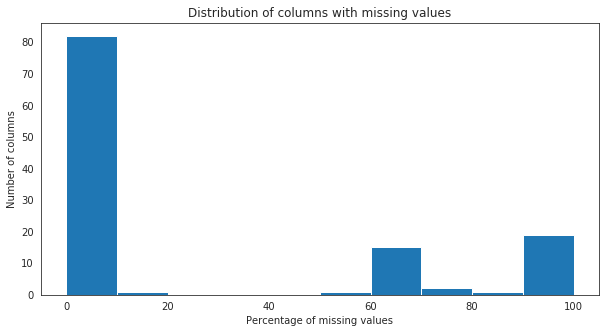

In [189]:
plt.hist(perc_missing.sort_values(ascending=False).values, bins=10);
plt.title('Distribution of columns with missing values');
plt.xlabel('Percentage of missing values');
plt.ylabel('Number of columns');

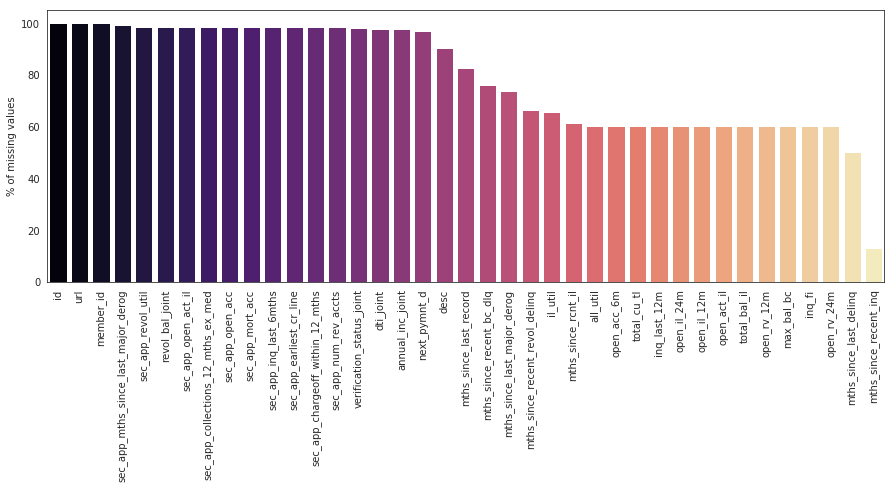

In [203]:
miss_over_ten = perc_missing[perc_missing > 10].sort_values(ascending=False)
plt.figure(figsize=(15, 5));
sns.barplot(x = np.arange(len(miss_over_ten)), y = miss_over_ten, palette='magma');

plt.xticks(np.arange(len(miss_over_ten)), miss_over_ten.index, rotation=90);
plt.ylabel('% of missing values', fontsize=13);

In [205]:
print('Number of columns with at least 10% of missing values: {}'.format( len(miss_over_ten) ) )

Number of columns with at least 10% of missing values: 39


There are 39 columns that have more than 10% of their values missing, with 38 having more than 50% of missing values. Since imputing such a large number of values will seriously impact modelling they will be dropped.  
Variable 'mths_since_recent_inq' requires some deeper analysis - maybe it would be reasonable to impute it's values with median.

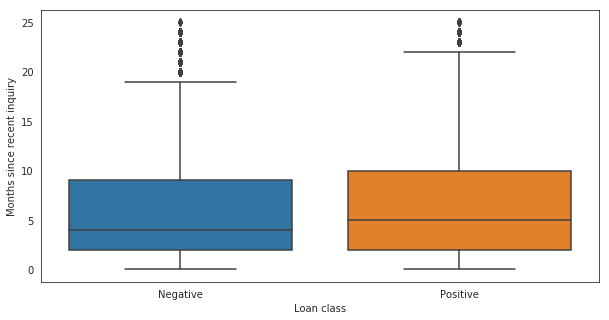

In [235]:
sns.boxplot(data=df_eda_train, y = 'mths_since_recent_inq', x = 'loan_classes');
plt.xticks(df_eda_train.loan_classes.unique(), ['Negative', 'Positive']);
plt.ylabel('Months since recent inquiry');
plt.xlabel('Loan class');

In [245]:
print('Pearson correlation {:3.3f}'\
      .format(df_eda_train[['mths_since_recent_inq', 'loan_classes']]\
              .corr(method='pearson').iloc[0, 1]))

Pearson correlation 0.055


In [259]:
inq_class = df_eda_train[df_eda_train['mths_since_recent_inq'].isna()].loan_classes.value_counts(ascending=True)

In [265]:
inq_pct_miss_neg = np.round(inq_class[0]/(inq_class[0] + inq_class[1])*100, 2)
print('Percentage of missing values for mths_since_recent_inq in negative loan class = {:2.2f}%'.format(inq_pct_miss_neg))

Percentage of missing values for mths_since_recent_inq in negative loan class = 16.63%


Distribution of variable 'mths_since_recent_inq' is asymetric, with strong right skewness. However there appears to be no significant correlation between this variable and loan class. Also distribution with regard to loan class appears to be similar, with mean for positive class slightly higher.  

Imputation of more than 10% of values with median will reduce variables' skewness and result in slight bias, therefore this variable will be dropped. However, there is no strong indication that this is 100% correct aproach and imputing with median is a feasible solution.

In [285]:
df_eda_train = df_eda_train.dropna(thresh=df_eda_train.shape[0]*0.9, axis=1)

In [286]:
df_eda_train.shape

(938681, 82)

In [287]:
eda_columns = df_eda_train.columns

Imputation of missing values for remaining columns will be done in later step in preprocessing.

#### Univariate analysis

Purpose of univariate analysis in this case is finding anomalies - values like 100 years of employment, income of several millions or interest rates above 100%.

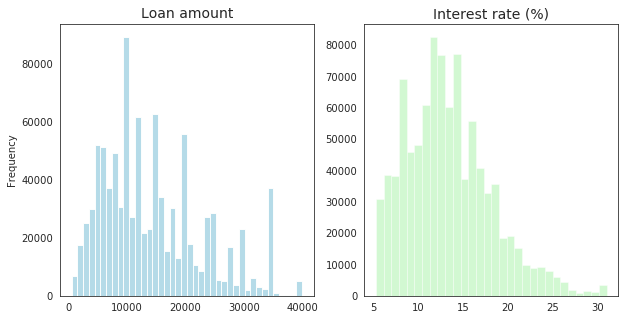

In [436]:
plt.figure()

plt.subplot(1, 2, 1)
plt.hist(df_eda_train.loan_amnt, alpha=0.9, color='lightblue', bins=40)
plt.title('Loan amount', fontsize=14)
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_eda_train.int_rate, alpha=0.4, color='lightgreen', bins=30)
plt.title('Interest rate (%)', fontsize=14)


plt.show()


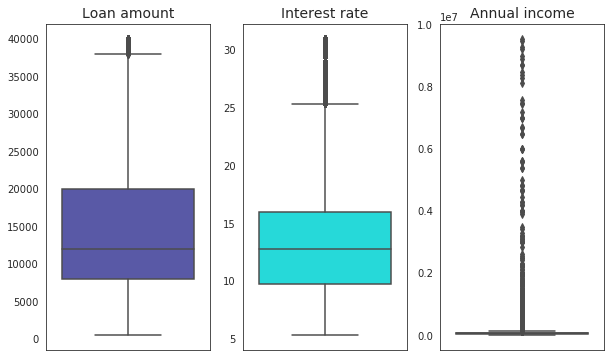

In [380]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
sns.boxplot(data=df_eda_train, y='loan_amnt', whis=1.5, color='blue', saturation=0.3)
plt.ylabel('')
plt.title('Loan amount', fontsize=14)

plt.subplot(1, 3, 2)
sns.boxplot(data=df_eda_train, y='int_rate', whis=1.5, color='cyan', saturation=0.7)
plt.title('Interest rate', fontsize=14)
plt.ylabel('')

plt.subplot(1, 3, 3)
sns.boxplot(data=df_eda_train, y='annual_inc', whis=1.5, color='red', saturation=0.6)
plt.title('Annual income', fontsize=14)
plt.ylabel('')
plt.show()


According to Lending Club website borrowers can borrow maximum \$40 000 , which is indeed maximum of column representing Loan Amount. It also has values above zero which indicates it's values are correct.

Values of interest rate seem to be in expected range, even though paying 30% interests does not seem like a good financial decision.

In [403]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
income_stats = pd.DataFrame(df_eda_train.annual_inc.describe(percentiles=[.01, .05, .25, .5, .75, .9, .995, .999])).T

income_stats.columns = ['Count', 'Mean', 'Std', 'Minimum', '1st Percentile', '5th Percentile', 'Q1', 'Q2', 'Q3'\
                        , '90th Percentile', '99.5th Percentile', '99.9th Percentile', 'Maximum']
income_stats

,Count,Mean,Std,Minimum,1st Percentile,5th Percentile,Q1,Q2,Q3,90th Percentile,99.5th Percentile,99.9th Percentile,Maximum
annual_inc,938678.00,76200.46,71331.26,0.00,18000.00,28000.00,45800.00,65000.00,90000.00,125000.00,320000.00,575000.00,9550000.00


However, value of 9.5M of annual income should at least raise a few eyebrows. Values for this column have long-tailed distribution - last 0.01 % of values ranges from \\$575k  to \\$9.5M. While it is not unusual for someone to have annual income above \\$500k (e.g. CEO of a large company) they are very unlikely to borrow small amounts with high interest rates - this is probably some kind of error and should be removed.  

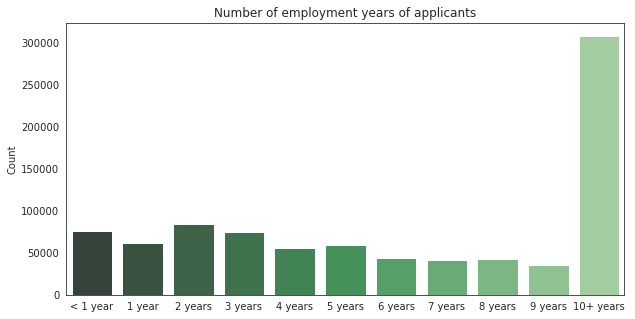

In [428]:
emp_length_map = {'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years': 5, '6 years':6\
                  , '7 years':7, '8 years':8, '9 years':9, '10+ years':10}
sns.countplot(data=df_eda_train, x='emp_length', palette='Greens_d', order = emp_length_map);
plt.title('Number of employment years of applicants');
plt.ylabel('Count');
plt.xlabel('');

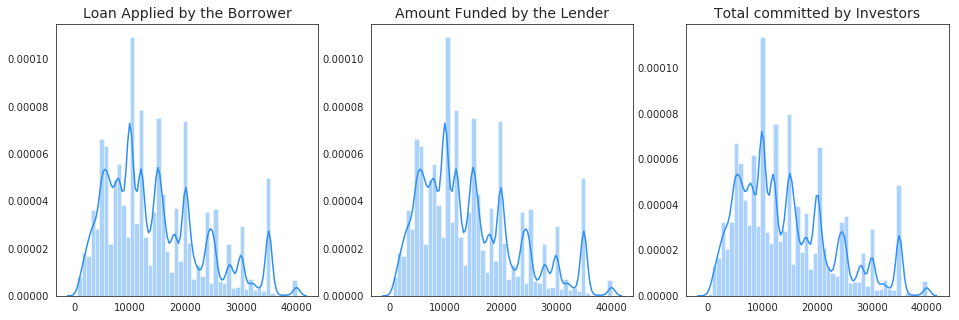

In [432]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = df_eda_train['loan_amnt'].values
funded_amount = df_eda_train['funded_amnt'].values
investor_funds = df_eda_train['funded_amnt_inv'].values

sns.distplot(loan_amount, ax=ax[0], color="#2F8FF1")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="#2F8FF6")
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="#2F8FFF")
ax[2].set_title("Total committed by Investors", fontsize=14)
plt.show()

Generally distributions of numerical variables are asymetric, mostly resembling gamma distribution. This is and indication that in preprocessing step it would be beneficial to normalize values, either using standard scaler or other transformation like Box-Cox.

#### Multivariate analysis

Purpose of multivariate analysis is to find relationships between variables that would differentiate classes of predicted variable or allow creation of new, derived features.  

Potentially interesting relationship would be one between loan classes and variables related to monetary value - loan amount and interest rates.  

Another deep and interesting topic is current financial situation of applicant - described by variables like total current balance off all accounts or number of installment accounts opened in last 12 months.  

Dataset contains also a few variables related to previous unsuccesfull financial activity - number of bankruptcies, number of charged off accounts in last 12 months or number of accounts on which borrower is now delinquent.

In [439]:
# TO DO:
# distributions by year
# distributions by grade
# distributions by purpose
# by term (duration of loan)
# distributions by employment length
# disbursement_method
# Analysis of variables related to financial instability - bankruptcy, unpaid previous loans
# Analysis of current financial situation


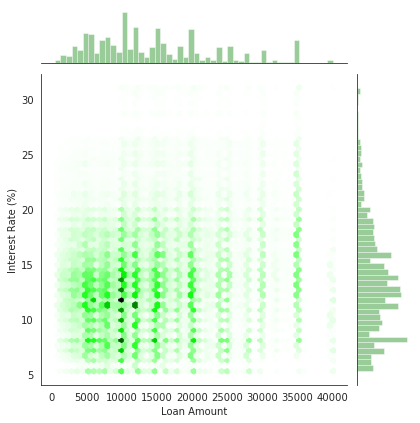

In [501]:
# loan amnt / interest rates
sns.jointplot('loan_amnt', 'int_rate',  data=df_eda_train, kind='hex', color='g')\
    .set_axis_labels('Loan Amount', 'Interest Rate (%)');

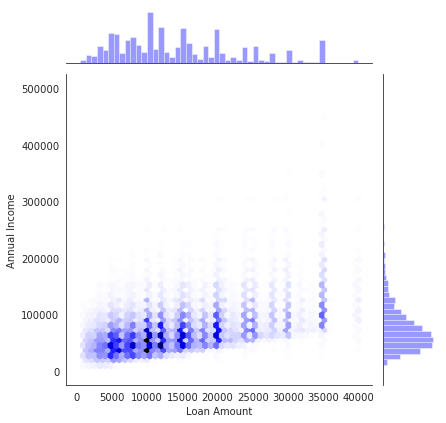

In [502]:
sns.jointplot('loan_amnt', 'annual_inc', data=df_eda_train[df_eda_train.annual_inc < 500000], kind='hex', color='b')\
    .set_axis_labels('Loan Amount', 'Annual Income');

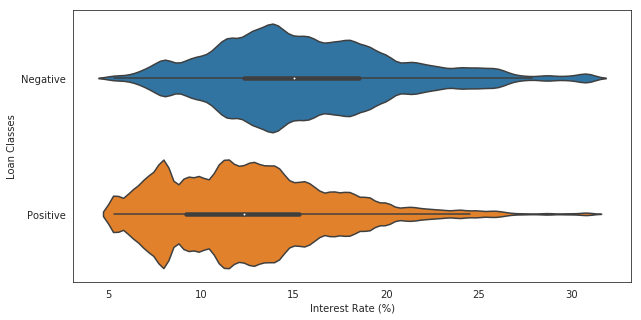

In [545]:
sns.violinplot(data=df_eda_train, y='loan_classes', x='int_rate', orient='h', scale='width');
plt.yticks([0, 1], ['Negative', 'Positive']);
plt.ylabel('Loan Classes');
plt.xlabel('Interest Rate (%)');

There is observable difference in interest rate by loan class - negative loans tend to have slightly higher interest rates than positive ones overall, however if interest rate is higher than 20% chances of loan being negative increase. On the other hand whe interest rates are below 10% chances of loan being paid increase.

In [525]:
all_zero = df_eda_train[['loan_classes','annual_inc']].groupby('loan_classes').count().unstack()[0]
all_one = df_eda_train[['loan_classes','annual_inc']].groupby('loan_classes').count().unstack()[1]

In [531]:
high_income = df_eda_train.query('annual_inc > 500000')[['annual_inc', 'loan_classes']]
high_zero = high_income.groupby('loan_classes').count().unstack()[0]
high_one = high_income.groupby('loan_classes').count().unstack()[1]

print(np.round(high_zero / all_zero * 100, 3))
print(np.round(high_one / all_one * 100, 3))

0.094
0.138


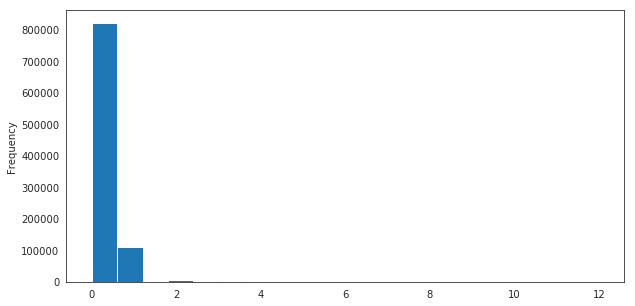

In [448]:
df_eda_train.pub_rec_bankruptcies.plot(kind='hist', bins=20);

In [441]:
df_eda_train.pub_rec_bankruptcies.value_counts()

0.00     820179
1.00     110591
2.00       5462
3.00       1060
4.00        269
5.00         96
6.00         34
7.00         12
8.00          8
12.00         1
11.00         1
Name: pub_rec_bankruptcies, dtype: int64

In [464]:
df_eda_train.loc[:, ['pub_rec_bankruptcies', 'loan_classes']].groupby([df_eda_train['loan_classes'], df_eda_train['pub_rec_bankruptcies'] ]).count()

pub_rec_bankruptcies  loan_classes
loan_classes pub_rec_bankruptcies                                    
0            0.00                                178552        178552
             1.00                                 27297         27297
             2.00                                  1469          1469
             3.00                                   255           255
             4.00                                    78            78
             5.00                                    22            22
             6.00                                    11            11
             7.00                                     4             4
             8.00                                     4             4
             11.00                                    1             1
1            0.00                                641627        641627
             1.00                                 83294         83294
             2.00                                  3993          3993
             3.00                                   805           805
             4.00                                   191           191
             5.00                                    74            74
             6.00                                    23            23
             7.00                                     8             8
             8.00                                     4             4
             12.00                                    1             1

### __Preprocessing__

#### Imputation of missing values

Dropping columns with more than 10% of missing values.

In [536]:
df.dropna(thresh=df.shape[0]*0.9, axis=1, inplace=True)

In [546]:
df = df[df_eda_train.columns]

Dropping rows with annual income more than \$500k 

In [552]:
df = df.query('annual_inc < 500000')

#### Encoding

In [ ]:
# remove categorical variables with multiple categories - emp_title, sub_grade?, 

In [ ]:
df.drop(columns=['emp_title', 'sub_grade'])

#### Feature engineering

In [ ]:
# flag for annual_inc > 500 000


#### Standarization